# Image classifier

In [1]:
import numpy as np
import tensorflow as tf

2025-04-20 23:23:06.111309: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745205786.126273    5758 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745205786.130791    5758 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745205786.143161    5758 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745205786.143176    5758 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745205786.143178    5758 computation_placer.cc:177] computation placer alr

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=5120)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1745205790.039852    5758 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5120 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:31:00.0, compute capability: 7.5


# Load the data

In [3]:
import os


data_dir = os.path.abspath('/mnt/f/Courses/4GeeksAcademy/DataScience/DeliverableExercises/alejandroNovellino-image-classifier-project/data/raw/train')

# set the image width and height
img_width = 120
img_height = 120

batch_size = 12

# train dataset
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels='inferred',
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.


In [4]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
val_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
class_names = train_ds.class_names
print(class_names)

['class_a', 'class_b']


Where the labels are:
- class_a - cat
- class_b - dog

# Visualize the data

2025-04-20 23:23:43.644001: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


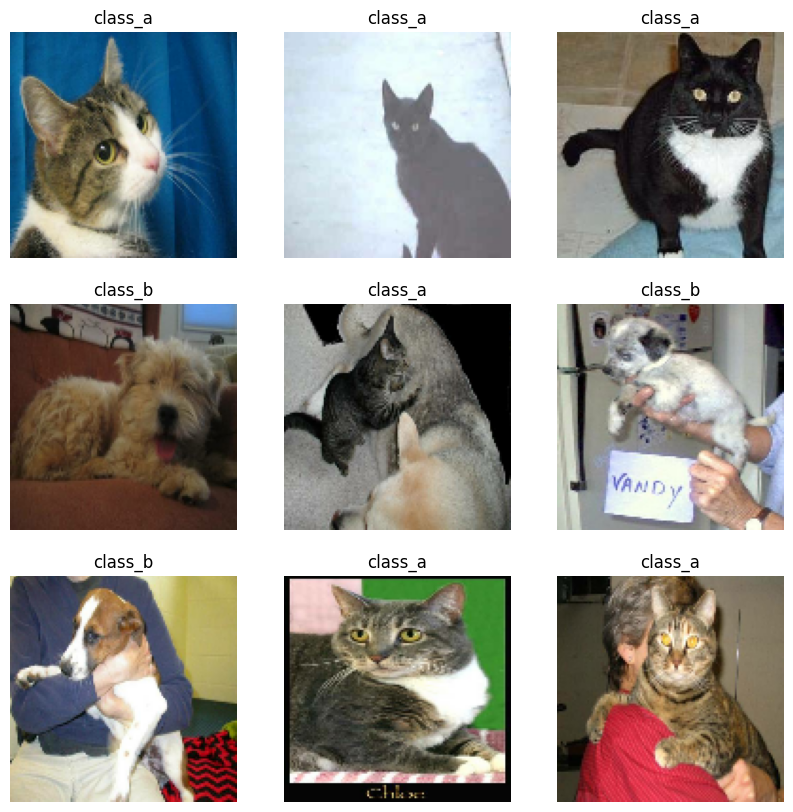

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Let's verify what is the content of train_ds

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(12, 120, 120, 3)
(12,)


The image_batch is a tensor of the shape (12, 120, 120, 3). This is a batch of 16 with shape 160x160x3 (the last dimension refers to color channels RGB and the images are 120x120 because that is the value we set on the **image_dataset_from_directory** function). The label_batch is a tensor of the shape (12,), these are corresponding **labels** to the 12 images.

# Configure the dataset for performance

We are going to use buffered prefetching, so we can yield data from disk without having I/O become blocking. The two important methods we should use when loading data are:

- **Dataset.cache** keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- **Dataset.prefetch** overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Now we standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

Now there are two ways to use this layer. We can apply it to the dataset by calling Dataset.map:

In [11]:
# normalize all the data
# normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

# let's print the first image to see the normalization
# image_batch, labels_batch = next(iter(normalized_train_ds))
# first_image = image_batch[0]
# print('Min and Max values:', np.min(first_image), '-', np.max(first_image))

Or we can include this layer in the model, the same can be done with the Resizing using the **tf.keras.layers.Resizing** layer.

# Now let's create the model (CNN)

This time we are following the models given to use:

In [15]:
from keras import Sequential, layers

num_classes = len(class_names)

model = Sequential([
    # set this Input layer to delete the warning
    layers.Input(shape=(img_height, img_width, 3)),
    # here is where the rescaling layer can be
    layers.Rescaling(1./255),
    # rest of the layers
    layers.Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.Conv2D(filters = 64,kernel_size = (3,3),padding = "same", activation = "relu"),
    layers.MaxPool2D(pool_size = (2,2),strides = (2,2)),
    layers.Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.MaxPool2D(pool_size = (2,2),strides = (2,2)),
    layers.Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.MaxPool2D(pool_size = (2,2),strides = (2,2)),
    layers.Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.MaxPool2D(pool_size = (2,2),strides = (2,2)),
    layers.Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.MaxPool2D(pool_size = (2,2),strides = (2,2)),
    layers.Flatten(),
    layers.Dense(units = 4096,activation = "relu"),
    layers.Dense(units = 4096,activation = "relu"),
    layers.Dense(units = 2, activation = "softmax"),
])

# Compile the model

This time we are going to use the **tf.keras.optimizers.Adam** optimizer and **tf.keras.losses.SparseCategoricalCrossentropy** loss function.

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Model summary

We can see all the layers of the network using the Keras **Model.summary** method:

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 120, 120, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 120, 120, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 120, 120, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 60, 60, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 60, 60, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 30, 30, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 30, 30, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 30, 30, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 15, 15, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 7, 7, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    18,878,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,382,658 (192.19 MB)

 Trainable params: 50,382,658 (192.19 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [18]:
# epoch to train
epochs = 20

# train
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


I0000 00:00:1745206831.492232    6177 service.cc:152] XLA service 0x7ff334003500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745206831.492279    6177 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2025-04-20 23:40:31.596035: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745206832.122813    6177 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-20 23:40:32.666627: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.39 = (f32[12,64,120,120]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,3,120,120]{3,2,1,0} %bitcast.6371, f32[64,3,3,3]{3,2,1,0} %bitcast.5964, f32[64]{0} %bitcast.7046), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_

   2/1667 ━━━━━━━━━━━━━━━━━━━━ 2:04 75ms/step - accuracy: 0.5208 - loss: 0.6996  

I0000 00:00:1745206838.651965    6177 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1548/1667 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.4950 - loss: 0.6944

2025-04-20 23:42:14.455182: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.39 = (f32[8,64,120,120]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,3,120,120]{3,2,1,0} %bitcast.6371, f32[64,3,3,3]{3,2,1,0} %bitcast.5964, f32[64]{0} %bitcast.7046), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_13_1/convolution" source_file="/home/a24/miniconda3/envs/tf-gpu-2/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-20 23:42:14.479145: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc

1667/1667 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4951 - loss: 0.6943

2025-04-20 23:42:26.751148: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.39 = (f32[12,64,120,120]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,3,120,120]{3,2,1,0} %bitcast.833, f32[64,3,3,3]{3,2,1,0} %bitcast.840, f32[64]{0} %bitcast.842), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_13_1/convolution" source_file="/home/a24/miniconda3/envs/tf-gpu-2/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-20 23:42:26.780066: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:

1667/1667 ━━━━━━━━━━━━━━━━━━━━ 137s 72ms/step - accuracy: 0.4951 - loss: 0.6943 - val_accuracy: 0.4924 - val_loss: 0.6935
Epoch 2/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 106s 63ms/step - accuracy: 0.5051 - loss: 0.6932 - val_accuracy: 0.4924 - val_loss: 0.6932
Epoch 3/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 106s 64ms/step - accuracy: 0.5042 - loss: 0.6932 - val_accuracy: 0.4924 - val_loss: 0.6932
Epoch 4/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 106s 64ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5076 - val_loss: 0.6931
Epoch 5/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 106s 64ms/step - accuracy: 0.4929 - loss: 0.6932 - val_accuracy: 0.4924 - val_loss: 0.6936
Epoch 6/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 106s 64ms/step - accuracy: 0.4905 - loss: 0.6934 - val_accuracy: 0.5076 - val_loss: 0.6931
Epoch 7/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 106s 64ms/step - accuracy: 0.4920 - loss: 0.6933 - val_accuracy: 0.4924 - val_loss: 0.6933
Epoch 8/20
1667/1667 ━━━━━━━━━━━━━━━━━━━━ 107s 64ms/step - accuracy: 0.5055 - lo

# Visualize training results

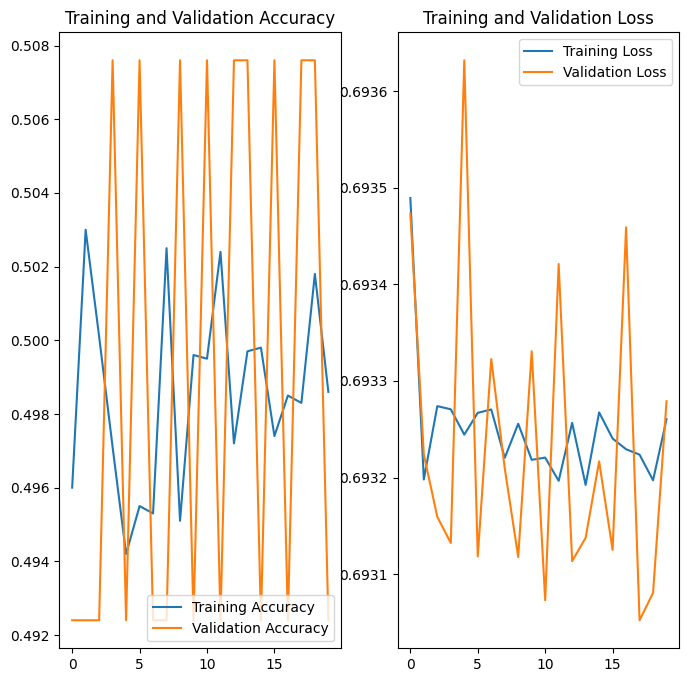

In [19]:
# get the values to graph
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# create the graphs
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Analysis

# Analyze the results

In [20]:
test_data_dir = '/mnt/f/Courses/4GeeksAcademy/DataScience/DeliverableExercises/alejandroNovellino-image-classifier-project/data/raw/test'

# test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 12500 files belonging to 1 classes.


In [ ]:
# make the prediction
y_pred = model.predict(test_ds)

In [ ]:
import pandas as pd

y_pred_df = pd.DataFrame(y_pred)
y_pred_df['predicted_class'] = y_pred_df.idxmax(axis=1)

In [ ]:
y_pred_df

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve


# calculate roc auc score
auc_score = roc_auc_score(test_ds.flatten(), y_pred)
print(f"AUC Score: {auc_score:.4f}")

In [ ]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(test_ds, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Cat Vs Dog classifier')
plt.legend()
plt.grid(True)
plt.show()

# Save the original model

In [21]:
save_dir = os.path.abspath('/mnt/f/Courses/4GeeksAcademy/DataScience/DeliverableExercises/alejandroNovellino-image-classifier-project/models')

model.save(f'{save_dir}/base_model.keras')

Now clear the memory to continue working

In [23]:
tf.keras.backend.clear_session(
    free_memory=True
)

# Fighting overfitting

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [ ]:
data_augmentation = Sequential([
    # set this Input layer to delete the warning
    layers.Input(shape=(img_height, img_width, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

Let's visualize a few augmented examples by applying data augmentation to the same image several times:

In [ ]:
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

We are not ging to apply this methodology because of performance issues.

## Dropout

Another technique to reduce overfitting is to introduce dropout regularization to the network.

When dropout is applied to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [ ]:
model_with_dropout = Sequential([
    # set this Input layer to delete the warning
    layers.Input(shape=(img_height, img_width, 3)),
    # here is where the rescaling layer can be
    # layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.Conv2D(filters = 64,kernel_size = (3,3),padding = "same", activation = "relu"),
    layers.MaxPool2D(pool_size = (2,2),strides = (2,2)),
    layers.Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.Conv2D(filters = 128, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.MaxPool2D(pool_size = (2,2),strides = (2,2)),
    layers.Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.Conv2D(filters = 256, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.MaxPool2D(pool_size = (2,2),strides = (2,2)),
    layers.Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.MaxPool2D(pool_size = (2,2),strides = (2,2)),
    layers.Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.Conv2D(filters = 512, kernel_size = (3,3), padding = "same", activation = "relu"),
    layers.MaxPool2D(pool_size = (2,2),strides = (2,2)),
    # dropout layer of 20%
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units = 4096,activation = "relu"),
    layers.Dense(units = 4096,activation = "relu"),
    layers.Dense(units = 2, activation = "softmax"),
])

# Compile and train the new model

In [ ]:
model_with_dropout.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
model_with_dropout.summary()

In [ ]:
epochs = 5

model_with_dropout_history = model_with_dropout.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# Visualize training results of the new model

In [ ]:
# get the values to graph
acc = model_with_dropout_history.history['accuracy']
val_acc = model_with_dropout_history.history['val_accuracy']

loss = model_with_dropout_history.history['loss']
val_loss = model_with_dropout_history.history['val_loss']

epochs_range = range(epochs)

# create the graphs
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict on new data

Lets use the model to classify an images that weren't included in the training or validation sets.

In [ ]:
test_data_dir = os.path.abspath('../data/raw/test/')

# train dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=42,
    image_size=(img_height, img_width),
)

# predict
predictions = model.predict(test_ds)
score = tf.nn.softmax(predictions)